# **Quora Duplicate Question Pairs Classification**

There are multiple approaches to this problem of quora duplicate questions classification like Tfidf, Deep Learning, Transformers etc. I have used two approaches here i.e. Tfidf + XGBoost Classifer and Transformers + XGBoost Classifier and will select the model with the best accuracy and other metrics.

**Method 1 : TF-IDF and XGBoost Classifier**

In [3]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.plotting import plot_confusion_matrix
import xgboost as xgb
import string
import joblib
import re
import os
import shutil

In [5]:
# Extract train and test files
shutil.unpack_archive("/kaggle/input/quora-question-pairs/train.csv.zip","train.csv")
shutil.unpack_archive("/kaggle/input/quora-question-pairs/test.csv.zip","test.csv")

In [6]:
# Read data
def read_data(filename,encoding="utf8"):
    df = pd.read_csv(filename)
    # Drop null values
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    print("\nNumber of records:",len(df))
    return df

In [10]:
# Load train data
df = read_data("/kaggle/working/train.csv/train.csv")

# Select relevant columns
df = df[["question1","question2","is_duplicate"]]
df.head()


Number of records: 404287


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
# Preprocessing

def preprocess_data(text):
    # conver to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())
    
    return text


In [12]:
# Apply pre-processing on a copy of the original dataframe

df_copy = df.copy() # Create a copy of the original dataframe
df_copy.loc[:,"question1"] = df_copy["question1"].apply(preprocess_data)
df_copy.loc[:,"question2"] = df_copy["question2"].apply(preprocess_data)
df_copy.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,how can increase the speed of my internet conn...,how can internet speed be increased by hacking...,0
3,why am mentally very lonely how can solve it,find the remainder when mathmath is divided by,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [13]:
# Label counts

df_copy['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [14]:
# Split dataset

df_train,df_dev = train_test_split(df_copy,
                                   test_size=0.3,
                                   stratify=df_copy['is_duplicate'],
                                   random_state=42)

print("Training data shape:",df_train.shape)
print("Dev data shape:",df_dev.shape)

Training data shape: (283000, 3)
Dev data shape: (121287, 3)


In [15]:
# Fit Tfidf Vectorizer

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_train['question1']+' '+df_train['question2'])
dev_tfidf = tfidf.transform(df_dev['question1']+' '+df_dev['question2'])

train_tfidf.shape,dev_tfidf.shape

((283000, 82854), (121287, 82854))

In [16]:
# Fit XGBoost Classifier and check accuracy on dev set

labels = df_train['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_tfidf,labels)

predictions = model_xgb.predict(dev_tfidf)
predictions = list(predictions)

print('Accuracy score:',accuracy_score(df_dev['is_duplicate'],predictions))

Accuracy score: 0.7493383462366123


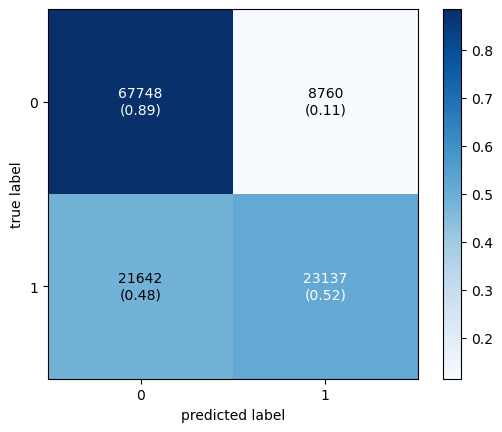

In [18]:
# Confusion Matrix
cm = confusion_matrix(df_dev['is_duplicate'],predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [19]:
# Classification Report

print("\t\tClassification Report\n\n:",classification_report(df_dev['is_duplicate'],predictions))

		Classification Report

:               precision    recall  f1-score   support

           0       0.76      0.89      0.82     76508
           1       0.73      0.52      0.60     44779

    accuracy                           0.75    121287
   macro avg       0.74      0.70      0.71    121287
weighted avg       0.75      0.75      0.74    121287



The accuracy score and f1 scores are pretty low with Tfidf.

**Method 2: Transformers and XGBoost Classifier**

We will use a CrossEncoder for training the sentence pairs. A CrossEncoder is like a Siamese BERT network which produces an output value between 0 and 1 indicating the similarity of the input sentence pair. A classifer can be trained on the similarity scores to predict labels.

In [7]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=570296732d2c127024e168ebd30170568d07d942992eba0067c608a04dbf0e55
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [8]:
from torch.utils.data import DataLoader
import torch
from sentence_transformers import util
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
import math

In [9]:
# Read data with raw sentences
df = read_data("/kaggle/working/train.csv/train.csv")

# Select relevant columns
df = df[["question1","question2","is_duplicate"]]
df.head()


Number of records: 404287


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
# Split dataset

df_train,df_dev = train_test_split(df,
                                   test_size=0.3,
                                   stratify=df['is_duplicate'],
                                   random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_dev.reset_index(drop=True,inplace=True)

print("Train data shape:",df_train.shape)
print("Dev data shape:",df_dev.shape)

Train data shape: (283000, 3)
Dev data shape: (121287, 3)


In [11]:
# Prepare data samples

def create_samples(data):
    samples = []
    for i in range(len(data)):
        samples.append(InputExample(texts=[data.loc[i,"question1"],data.loc[i,"question2"]],
                                              label=int(data.loc[i,"is_duplicate"])))
    return samples

In [12]:
train_samples = create_samples(df_train)
dev_samples = create_samples(df_dev)

print("Number of train samples:",len(train_samples))
print("Number of dev samples:",len(dev_samples))

Number of train samples: 283000
Number of dev samples: 121287


In [13]:
# Define Configuration

train_batch_size = 16
num_epochs = 2
model_path = "output/training_quora"

#We use distilroberta-base with a single label, i.e., it will output a value between 0 and 1 indicating the similarity of the two questions

model = CrossEncoder(model_name="distilroberta-base", num_labels=1)

# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

# We add an evaluator, which evaluates the performance during training
evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, name='Quora-dev')

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path=model_path,
          show_progress_bar=True)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias',

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/17688 [00:00<?, ?it/s]

Iteration:   0%|          | 0/17688 [00:00<?, ?it/s]

In [14]:
# Cosine Similarity predictions on train set

train = [] # create list of train data question pairs
for i in range(len(df_train)):
    train.append([df_train.loc[i,'question1'],df_train.loc[i,'question2']])

predictions = model.predict(train,show_progress_bar=True)
predictions

Batches:   0%|          | 0/8844 [00:00<?, ?it/s]

array([9.7388941e-01, 6.3137675e-04, 3.7562340e-01, ..., 8.5639851e-03,
       4.2043296e-03, 9.1427000e-04], dtype=float32)

In [15]:
cosine_sim = list(predictions)
df_1 = df_train.copy()
df_1['cosine_sim'] = cosine_sim # Add a column for cosine similarity to a copy of train data
df_1.head()

,question1,question2,is_duplicate,cosine_sim
0,Which are the best books for iit jam mathematics?,What are the best books for IIT-JAM mathematics?,1,0.973889
1,What are the best Photo startups?,What is a good photo?,0,0.000631
2,How can I find a job?,What is the fastest way to find a job?,1,0.375623
3,Which water purifier company provide best afte...,"I am planning to purchase water purifier, whic...",1,0.896129
4,Can I add an app to my Vizio smart TV?,Are there any YouTube like apps for sharing on...,0,0.000396


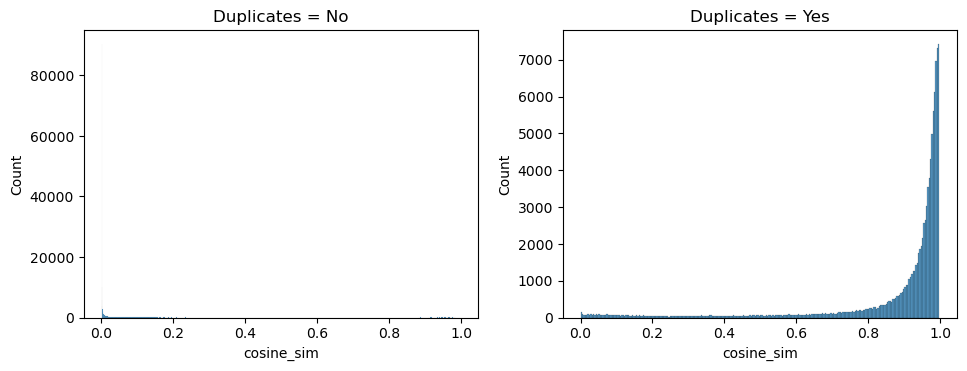

In [16]:
# Visualize distribution of duplicate and non-duplicate data

# filter dataframes with duplicate == Yes
df_dup_1 = df_1[df_1['is_duplicate']==1]
df_dup_1.head()

# filter dataframe with duplicate == No
df_dup_0 = df_1[df_1['is_duplicate']==0]
df_dup_0.head()

# Histogram
import matplotlib.pyplot as plt
import seaborn as sns

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (10,4))
fig.tight_layout(pad=3)
sns.histplot(df_dup_0['cosine_sim'],kde=False,ax=ax1)
sns.histplot(df_dup_1['cosine_sim'],kde=False,ax=ax2)
ax1.set_title('Duplicates = No')
ax2.set_title('Duplicates = Yes')
plt.show()

We can see from the plots that majority of the duplicate questions have a cosine similarity in the range 0.8 - 0.99 and majority of the non-duplicate questions have a cosine similarity in the range of 0-0.1

In [17]:
# Model building using XGBClassifier

X = df_1[['cosine_sim']]
y = df_1['is_duplicate']

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X,y)

# Check accuracy on dev set

dev = [] # create list of dev data question pairs
for i in range(len(df_dev)):
    dev.append([df_dev.loc[i,'question1'],df_dev.loc[i,'question2']])

predictions = model.predict(dev,show_progress_bar=True) # cosine similarity predictions

df_2 = df_dev.copy()
df_2["cosine_sim"] = list(predictions) # Add a new column for cosine similarity
X_dev = df_2[["cosine_sim"]]
y_dev = df_2["is_duplicate"]

# Predicting labels i.e Duplicate or Not Duplicate
y_predict_xgb = model_xgb.predict(X_dev)

print('Accuracy Score:',accuracy_score(y_dev,y_predict_xgb))

Batches:   0%|          | 0/3791 [00:00<?, ?it/s]

Accuracy Score: 0.8981918919587425


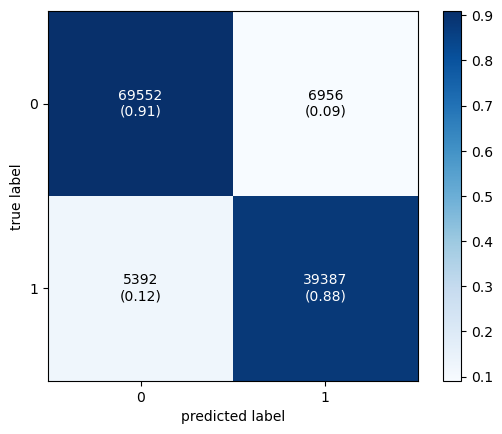

In [18]:
# Confusion Matrix

cm = confusion_matrix(y_dev,y_predict_xgb)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [19]:
# Classification Report

print("\t\tClassification Report\n\n:",classification_report(y_dev,y_predict_xgb))

		Classification Report

:               precision    recall  f1-score   support

           0       0.93      0.91      0.92     76508
           1       0.85      0.88      0.86     44779

    accuracy                           0.90    121287
   macro avg       0.89      0.89      0.89    121287
weighted avg       0.90      0.90      0.90    121287



The accuracy along with other metrics like f1 score are far better than what we got with the Tfidf approach.

Predicting the test set

In [20]:
# Read the test set

df_test = pd.read_csv(r"/kaggle/working/test.csv/test.csv",encoding="utf8",dtype=object)
df_test.dropna(inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [21]:
# Cosine Similarity predictions on test set

test = [] # create list of test data question pairs
for i in range(len(df_test)):
    test.append([df_test.loc[i,'question1'],df_test.loc[i,'question2']])

predictions = model.predict(test,show_progress_bar=True)
predictions

Batches:   0%|          | 0/111359 [00:00<?, ?it/s]

array([2.5094922e-03, 1.6457531e-01, 5.1467196e-04, ..., 4.2800361e-04,
       8.1884366e-04, 9.4690728e-01], dtype=float32)

In [22]:
df_test["cosine_sim"] = list(predictions) # Add a new column for cosine similarity
X_test = df_test[["cosine_sim"]]

# Predicting labels i.e Duplicate or Not Duplicate
y_test = model_xgb.predict(X_test)
df_test["is_duplicate"] = y_test

# Prepare submission
submission = df_test[["test_id","is_duplicate"]]
submission.head()

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [23]:
# Save to file
submission.to_csv("submission.csv",index=False)